<a href="https://colab.research.google.com/github/dev02chandan/recommendation-systems/blob/main/Item_Based_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Item-based collaborative filtering is also called item-item collaborative filtering. It is a type of recommendation system algorithm that uses item similarity to make product recommendations.

Points to understand
* What is item-based (item-item) collaborative filtering?
* How to create a user-product matrix?
* How to identify similar items?
* How to rank items for the recommendation?

Let's get started!

 Item-Based Collaborative Filtering Recommendation Algorithm



Item-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that users like similar products and dislike similar products, so they give similar ratings to similar products.

Item-based collaborative filtering algorithm usually has the following steps:

1. Calculate item similarity scores based on all the user ratings.
2. Identify the top n items that are most similar to the item of interest.
3. Calculate the weighted average score for the most similar items by the user.
4. Rank items based on the score and pick top n items to recommend.

Import Python Libraries

Import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.
Also import `seaborn` for visualization and `cosine_similarity` for calculating similarity scores.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

# Visualization
import matplotlib.pyplot as plt

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

Download And Read In Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read in data
data1 = pd.read_csv('/content/drive/MyDrive/RS/4ratings.csv')

# Take a look at the data
data1.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# Get the dataset information
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
# Number of users
print("The ratings dataset has ", data1['userId'].nunique(), "unique users")

# Number of movies
print("The ratings dataset has ", data1['movieId'].nunique(), "unique movies")

# Number of ratings
print("The ratings dataset has ", data1['rating'].nunique(), "unique ratings")

# List of unique ratings
print("the unique ratings are ", sorted(data1['rating'].unique()))

The ratings dataset has  610 unique users
The ratings dataset has  9724 unique movies
The ratings dataset has  10 unique ratings
the unique ratings are  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Read in the movies data to get the movie names.



In [6]:
# Read in data
data2 = pd.read_csv('/content/drive/MyDrive/RS/4movies.csv')

# Take a look at the data
data2.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Using `movieID` as the matching key, Append movie information to the rating dataset


In [7]:
# Merge ratings and movies datasets
data = pd.merge(data1, data2, on='movieId')

# Take a look at the data
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


# Exploratory Data Analysis (EDA)

Perform Required EDA and write inferences for all

In [9]:
# Aggregate by movie
agg_rating = data.groupby('title').agg(
    mean_rating = ('rating', 'mean'),
    number_of_ratings = ('rating', 'count')).reset_index()

agg_rating.head()

,title,mean_rating,number_of_ratings
0,'71 (2014),4.0,1
1,'Hellboy': The Seeds of Creation (2004),4.0,1
2,'Round Midnight (1986),3.5,2
3,'Salem's Lot (2004),5.0,1
4,'Til There Was You (1997),4.0,2


In [10]:
# Keep the movies with over 100 ratings
over100ratings = agg_rating[agg_rating['number_of_ratings'] > 100]
over100ratings.head()

,title,mean_rating,number_of_ratings
74,2001: A Space Odyssey (1968),3.894495,109
207,Ace Ventura: Pet Detective (1994),3.040373,161
298,Aladdin (1992),3.792350,183
327,Alien (1979),3.969178,146
333,Aliens (1986),3.964286,126


In [11]:
# Check the information of the dataframe
over100ratings.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


 what the most popular movies and their ratings are.

In [12]:
# Check popular movies
over100ratings.sort_values(by='number_of_ratings', ascending=False)

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278
...,...,...,...
3281,Full Metal Jacket (1987),4.098039,102
3845,Heat (1995),3.946078,102
1833,Cliffhanger (1993),3.034653,101
6394,Outbreak (1995),3.425743,101


To keep only the 134 movies with more than 100 ratings, we need to join the movie with the user-rating level dataframe.

`how='inner'` and `on='title'` ensure that only the movies with more than 100 ratings are included.

In [13]:
# Merge data
df = data.merge(over100ratings, how='inner', on='title')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             19788 non-null  int64  
 1   movieId            19788 non-null  int64  
 2   rating             19788 non-null  float64
 3   timestamp          19788 non-null  int64  
 4   title              19788 non-null  object 
 5   genres             19788 non-null  object 
 6   mean_rating        19788 non-null  float64
 7   number_of_ratings  19788 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.4+ MB


After filtering the movies with over 100 ratings, we have 597 users that rated 134 movies.

In [14]:
# Number of users
print("The ratings dataset has ", df['userId'].nunique(), "unique users")

# Number of movies
print("The ratings dataset has ", df['movieId'].nunique(), "unique movies")

# Number of ratings
print("The ratings dataset has ", df['rating'].nunique(), "unique ratings")

# List of unique ratings
print("the unique ratings are ", sorted(df['rating'].unique()))

The ratings dataset has  597 unique users
The ratings dataset has  134 unique movies
The ratings dataset has  10 unique ratings
the unique ratings are  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


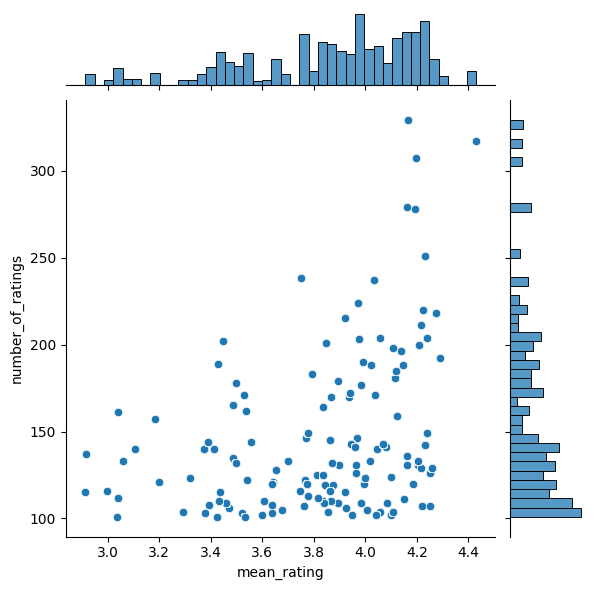

In [15]:
# Visulization and write the inferences
sns.jointplot(x='mean_rating', y='number_of_ratings', data=df)

Create User-Movie Matrix

1.   List item
2.   List item



In step 4, we will transform the dataset into a matrix format. The rows of the matrix are movies, and the columns of the matrix are users. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [16]:
# Create user-item matrix
user_item_matrix = df.pivot_table(index='title', columns='userId', values='rating')
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,3.0,NaN,4.5
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,3.5,NaN,3.0
Aladdin (1992),NaN,NaN,NaN,4.0,4.0,5.0,3.0,NaN,NaN,4.0,...,NaN,NaN,NaN,3.0,3.5,NaN,NaN,3.0,NaN,NaN
Alien (1979),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,4.0,3.0,4.0,NaN,4.5
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,3.5,NaN,4.5,NaN,5.0


#  Data Normalization

In Step 5, we will normalize the data by subtracting the average rating of each movie. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.

After normalization, the ratings less than the movie's average rating get a negative value, and the ratings more than the movie's average rating get a positive value.

In [17]:
# Normalize user-item matrix
matrix_norm = user_item_matrix.subtract(user_item_matrix.mean(axis=1), axis='rows')

In [18]:
matrix_norm

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,0.105505,NaN,NaN,NaN,...,NaN,NaN,1.105505,NaN,NaN,1.105505,NaN,-0.894495,NaN,0.605505
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-0.040373,-0.040373,NaN,NaN,NaN,NaN,...,NaN,-1.040373,NaN,-1.040373,NaN,NaN,NaN,0.459627,NaN,-0.040373
Aladdin (1992),NaN,NaN,NaN,0.20765,0.207650,1.207650,-0.792350,NaN,NaN,0.20765,...,NaN,NaN,NaN,-0.792350,-0.29235,NaN,NaN,-0.792350,NaN,NaN
Alien (1979),0.030822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.030822,NaN,NaN,0.030822,-0.969178,0.030822,NaN,0.530822
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035714,NaN,NaN,-0.464286,NaN,0.535714,NaN,1.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Usual Suspects, The (1995)",0.762255,NaN,NaN,NaN,-0.237745,-3.237745,0.262255,0.762255,NaN,NaN,...,0.762255,0.762255,NaN,NaN,NaN,0.262255,NaN,0.262255,NaN,-0.237745
WALL·E (2008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.942308,NaN,NaN,NaN,NaN,-0.057692,NaN,NaN,NaN,0.442308
Waterworld (1995),NaN,NaN,NaN,NaN,NaN,0.086957,NaN,0.086957,NaN,NaN,...,NaN,0.086957,NaN,0.086957,NaN,NaN,0.086957,0.086957,0.086957,NaN


#  Calculate Similarity Score

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the item similarity matrix using Pearson correlation.

In [19]:
# Item similarity matrix using Pearson correlation
item_similarity_pearson = matrix_norm.T.corr(method='pearson')
item_similarity_pearson

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),1.000000,-0.036319,0.017446,0.318523,0.317386,0.324150,0.193592,0.152405,0.011490,0.478877,...,-0.108291,-0.012451,-0.041791,-0.458642,0.152271,0.245279,0.100172,-0.447306,0.087803,-0.123862
Ace Ventura: Pet Detective (1994),-0.036319,1.000000,0.302193,-0.208017,-0.107524,-0.030425,0.040435,0.065549,0.173855,0.245829,...,0.139896,0.188089,0.054408,0.176930,-0.007853,-0.061520,0.170717,0.176155,0.051239,0.045676
Aladdin (1992),0.017446,0.302193,1.000000,0.026514,0.151152,0.445204,0.127764,0.262014,0.367076,0.015038,...,0.333687,0.562311,-0.069176,0.137215,0.171330,0.153934,0.272375,0.065342,0.164459,0.285480
Alien (1979),0.318523,-0.208017,0.026514,1.000000,0.705925,0.387215,0.215751,0.035373,-0.006804,0.378709,...,0.199538,0.178620,0.108327,0.022007,-0.098813,0.350428,0.270697,0.119849,0.117749,0.030257
Aliens (1986),0.317386,-0.107524,0.151152,0.705925,1.000000,0.540458,0.111452,0.139326,0.076674,0.221920,...,0.369971,0.287243,0.084792,0.092412,0.195581,0.296933,0.294852,-0.014274,0.111864,0.225923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Usual Suspects, The (1995)",0.245279,-0.061520,0.153934,0.350428,0.296933,0.334559,0.350545,0.276079,0.280924,0.182520,...,0.143424,0.064293,0.255347,-0.390032,0.468998,1.000000,0.378580,-0.194911,0.220837,0.173727
WALL·E (2008),0.100172,0.170717,0.272375,0.270697,0.294852,0.102326,0.216398,0.042043,0.060699,0.165662,...,0.303725,0.138136,0.513187,-0.162762,0.496807,0.378580,1.000000,-0.112344,0.095842,0.126949
Waterworld (1995),-0.447306,0.176155,0.065342,0.119849,-0.014274,-0.322291,-0.216045,-0.187477,0.180433,-0.094090,...,0.092716,0.141998,0.252467,0.191565,-0.200842,-0.194911,-0.112344,1.000000,0.136267,0.115242


In [20]:
type(item_similarity_pearson)

pandas.core.frame.DataFrame

 Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [21]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.T.fillna(0))
item_similarity_cosine

array([[ 1.        ,  0.00692025, -0.12568941, ..., -0.1592809 ,
        -0.01900557,  0.27237188],
       [ 0.00692025,  1.        ,  0.        , ...,  0.00672395,
         0.16045371,  0.17086429],
       [-0.12568941,  0.        ,  1.        , ...,  0.02838503,
         0.        ,  0.09460207],
       ...,
       [-0.1592809 ,  0.00672395,  0.02838503, ...,  1.        ,
         0.25451096, -0.18786424],
       [-0.01900557,  0.16045371,  0.        , ...,  0.25451096,
         1.        , -0.17211855],
       [ 0.27237188,  0.17086429,  0.09460207, ..., -0.18786424,
        -0.17211855,  1.        ]])

In [22]:
type(item_similarity_cosine)

numpy.ndarray

In [47]:
def cosine_similarity_matrix(matrix):
    normalized_matrix = matrix / np.linalg.norm(matrix, axis=1, keepdims=True)
    similarity_matrix = normalized_matrix @ normalized_matrix.T
    return similarity_matrix

In [51]:
matrix_norm = matrix_norm.fillna(0)

In [52]:
matrix_array = matrix_norm.to_numpy()

In [53]:
cosine_similarity_matrix = cosine_similarity(matrix_array)

In [54]:
cosine_similarity_df = pd.DataFrame(cosine_similarity_matrix, index=matrix_norm.index, columns=matrix_norm.index)

In [56]:
cosine_similarity_df

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),1.000000,-0.008960,0.014156,0.187477,0.188516,0.097358,0.064747,0.052466,0.005497,0.261397,...,-0.037609,-0.005055,-0.016711,-0.079667,0.036495,0.115129,0.016863,-0.085436,0.038729,-0.059299
Ace Ventura: Pet Detective (1994),-0.008960,1.000000,0.183498,-0.062225,-0.027283,-0.013399,0.012136,0.018744,0.056508,0.064444,...,0.082617,0.062237,0.023361,0.065646,-0.003456,-0.021846,0.060238,0.094016,0.015250,0.016827
Aladdin (1992),0.014156,0.183498,1.000000,0.010228,0.043684,0.081690,0.052173,0.069715,0.100167,0.021315,...,0.194541,0.248974,-0.026542,0.047567,0.029116,0.056808,0.058312,0.039381,0.060715,0.089869
Alien (1979),0.187477,-0.062225,0.010228,1.000000,0.520444,0.134302,0.098673,0.024811,0.003648,0.176312,...,0.082025,0.081222,0.043616,0.025765,-0.031031,0.117998,0.065169,0.024307,0.048260,0.011181
Aliens (1986),0.188516,-0.027283,0.043684,0.520444,1.000000,0.135293,0.046927,0.067812,0.033981,0.103376,...,0.129318,0.103999,0.036126,0.034266,0.046058,0.107881,0.057253,-0.005422,0.040446,0.114377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Usual Suspects, The (1995)",0.115129,-0.021846,0.056808,0.117998,0.107881,0.103715,0.111209,0.112053,0.078141,0.073012,...,0.062420,0.019405,0.123420,-0.124879,0.122451,1.000000,0.112768,-0.086303,0.080339,0.061982
WALL·E (2008),0.016863,0.060238,0.058312,0.065169,0.057253,0.033769,0.059227,0.023940,0.025474,0.023721,...,0.055025,0.051315,0.171498,-0.025506,0.338087,0.112768,1.000000,-0.014281,0.028101,0.048427
Waterworld (1995),-0.085436,0.094016,0.039381,0.024307,-0.005422,-0.065236,-0.026345,-0.043514,0.044644,-0.023852,...,0.055438,0.034628,0.097165,0.082651,-0.027211,-0.086303,-0.014281,1.000000,0.033481,0.023013


In the movie similarity matrix, the values range from -1 to 1, where -1 means opposite movie similarity and 1 means very high movie similarity.

# Predict User's Rating For One Movie

In step 7, we will predict a user's rating for one movie. Let's use user 1 and the movie American Pie as an example.

The prediction follows the process below:
1. Create a list of the movies that user 1 has watched and rated.
2. Rank the similarities between the movies user 1 rated and American Pie.
3. Select top n movies with highest similarity scores.
4. Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1.

Now let's implement the process using Python.

Firstly, we removed all the movies that have a missing rating for user 1, and sorted the movies by the ratings.

In [23]:
# Pick a user ID
picked_userid = 1

# Pick a movie
picked_movie = 'American Pie (1999)'

# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={1:'rating'})

picked_userid_watched.head()

,title,rating
0,Dumb & Dumber (Dumb and Dumber) (1994),1.939850
1,Indiana Jones and the Temple of Doom (1984),1.361111
2,X-Men (2000),1.300752
3,E.T. the Extra-Terrestrial (1982),1.233607
4,Ghostbusters (a.k.a. Ghost Busters) (1984),1.225000


We can see that user 1's favorite movie is Dumb and Dumber, followed by Indiana Jones and the Temple of Doom.

Next, we get the similarity score of the movie American Pie with the movie user 1 has watched, and pick the top 5 movies with the highest similarity score.

In [25]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity_pearson[[picked_movie]].reset_index().rename(columns={'American Pie (1999)':'similarity_score'})

# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                            right=picked_movie_similarity_score,
                                            on='title',
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

,title,rating,similarity_score
52,Mission: Impossible (1996),-0.537037,0.510888
47,Twister (1996),-0.321138,0.476518
16,Star Wars: Episode I - The Phantom Menace (1999),0.892857,0.443614
10,"Fugitive, The (1993)",1.007895,0.442128
19,"Green Mile, The (1999)",0.851351,0.429560


After that, calculate the weighted average of ratings and similarities scores, so the movies with higher similarity scores get more weight. This weighted average is the predicted rating for American Pie by user 1.

In [26]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'The predicted rating for {picked_movie} by user {picked_userid} is {predicted_rating}' )

The predicted rating for American Pie (1999) by user 1 is 0.338739


# Movie Recommendation


1. Create a list of movie that the target user has not watched before.
2. Loop through the unwatched movie and create predicted scores for each movie.
3. Rank the predicted score of unwatched movie from high to low.
4. Select the top k movies as the recommendations for the target user.

The Python function below implemented the four steps. With the input of `picked_userid`, `number_of_similar_items`, and `number_of_recommendations`, we can get the top movies for the user and their corresponding ratings. Note that the ratings are normalized by extracting the average rating for the movie, so we need to add the average value back to the predicted ratings if we want the predicted ratings to be on the same scale as the original ratings.

In [28]:
# Item-based recommendation function
def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[1]==True]['title'].values.tolist()

  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={1:'rating'})

  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}

  # Loop through unwatched movies
  for picked_movie in picked_userid_unwatched:
    # Calculate the similarity score of the picked movie iwth other movies
    picked_movie_similarity_score = item_similarity_pearson[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                right=picked_movie_similarity_score,
                                                on='title',
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Get recommendations
recommended_movie = item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie

[('Austin Powers: The Spy Who Shagged Me (1999)', 1.096288),
 ('Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 0.92924),
 ('Lord of the Rings: The Return of the King, The (2003)', 0.926824)]


# Summary

In this notebook, we've implemented an item-based collaborative filtering approach for movie recommendations. The main steps undertaken are:

1. **Data Loading**: We loaded movie details and user ratings from the provided datasets.
2. **User-Item Matrix Creation**: We transformed the ratings data into a matrix format where movies are represented by rows, and users by columns.
3. **Matrix Normalization**: To account for varying mean ratings given by different users and for different movies, we normalized the user-item matrix by subtracting the mean rating of each movie.
4. **Recommendation Function**: We developed an `item_based_rec` function that recommends movies to a user based on the cosine similarity between items. The function considers the movies a user hasn't watched, computes similarity scores with the movies the user has watched, and predicts potential ratings for the unwatched movies. The top N movies with the highest predicted ratings are then recommended to the user.
5. **Testing**: We tested the recommendation function for a sample user (user ID 1) and successfully obtained a list of recommended movies.

The item-based collaborative filtering approach provides personalized movie recommendations by considering the similarity between movies and leveraging the ratings provided by users. This method is particularly useful when we have a large number of users, as it only requires item-item similarity computations once and can then provide recommendations to any user.


# Part (B)

(a) Create a sample dictionary of users with web series and their ratings

(b) Create a function to print the unique set of web series

(c) Create a function to implement cosine similarity between two items

Item Based Collaborative consists of two phases:

#1st phase

(a) Find Similarity between the target item with all other remaining items.

#2nd phase

(a) Recommending web series to the target user which are most similar to the items which has already seen by the user.

(b) Create a function to find seen web series and unseen web series to the target user.

(c) Create a function to give recommendations.

In [ ]:
users_ratings = {
    'Alice': {
        'Stranger Things': 5,
        'The Crown': 4,
        'The Witcher': 3,
        'Breaking Bad': 5
    },
    'Bob': {
        'Stranger Things': 4,
        'The Crown': 5,
        'Money Heist': 4
    },
    'Charlie': {
        'The Witcher': 5,
        'Breaking Bad': 4,
        'Money Heist': 3,
        'Peaky Blinders': 5
    },
    'David': {
        'Stranger Things': 2,
        'The Crown': 3,
        'The Witcher': 5,
        'Money Heist': 4,
        'Peaky Blinders': 4
    }
}

users_ratings

{'Alice': {'Stranger Things': 5,
  'The Crown': 4,
  'The Witcher': 3,
  'Breaking Bad': 5},
 'Bob': {'Stranger Things': 4, 'The Crown': 5, 'Money Heist': 4},
 'Charlie': {'The Witcher': 5,
  'Breaking Bad': 4,
  'Money Heist': 3,
  'Peaky Blinders': 5},
 'David': {'Stranger Things': 2,
  'The Crown': 3,
  'The Witcher': 5,
  'Money Heist': 4,
  'Peaky Blinders': 4}}

In [ ]:
def unique_web_series(user_ratings):
    """Returns a set of unique web series from the given user ratings dictionary."""
    web_series_set = set()
    for series in user_ratings.values():
        web_series_set.update(series.keys())
    return web_series_set

unique_series = unique_web_series(users_ratings)
unique_series


{'Breaking Bad',
 'Money Heist',
 'Peaky Blinders',
 'Stranger Things',
 'The Crown',
 'The Witcher'}

In [ ]:
def dot_product(A, B):
    """Returns the dot product of two vectors."""
    return sum(a * b for a, b in zip(A, B))


def magnitude(vector):
    """Returns the magnitude (or norm) of a vector."""
    return sum(x**2 for x in vector) ** 0.5


def cosine_similarity(A, B):
    """Returns the cosine similarity between two vectors."""
    return dot_product(A, B) / (magnitude(A) * magnitude(B))


# Test the cosine similarity function
A = [1, 2, 3]
B = [1, 2, 4]
cosine_similarity(A, B)


0.9914601339836675

In [ ]:
def item_similarity(target_series, user_ratings):
    """Returns the cosine similarity of the target web series with all other web series."""

    # Create a vector for the target series
    target_vector = [user_ratings[user].get(target_series, 0) for user in user_ratings]

    similarities = {}

    # Calculate similarity with other series
    for series in unique_web_series(user_ratings):
        if series == target_series:
            continue
        series_vector = [user_ratings[user].get(series, 0) for user in user_ratings]
        similarity_score = cosine_similarity(target_vector, series_vector)
        similarities[series] = similarity_score

    return similarities


In [ ]:
similarity_with_stranger_things = item_similarity("Stranger Things", users_ratings)
similarity_with_stranger_things


{'The Crown': 0.9697651491183029,
 'Breaking Bad': 0.5820252464746485,
 'Peaky Blinders': 0.18624807887188752,
 'Money Heist': 0.5587442366156625,
 'The Witcher': 0.485185424782985}

In [ ]:
def seen_and_unseen_series(user, user_ratings):

    seen_series = set(user_ratings[user].keys())
    all_series = unique_web_series(user_ratings)
    unseen_series = all_series - seen_series

    return seen_series, unseen_series


In [ ]:
seen_by_charlie, unseen_by_charlie = seen_and_unseen_series("Charlie", users_ratings)
seen_by_charlie, unseen_by_charlie

({'Breaking Bad', 'Money Heist', 'Peaky Blinders', 'The Witcher'},
 {'Stranger Things', 'The Crown'})

In [ ]:
def recommend_web_series(user, user_ratings):
    """Recommend web series to the user based on the web series they've seen."""

    seen_series, unseen_series = seen_and_unseen_series(user, user_ratings)

    recommendation_scores = {series: 0 for series in unseen_series}

    for seen in seen_series:
        similarities = item_similarity(seen, user_ratings)
        for unseen in unseen_series:
            recommendation_scores[unseen] += similarities[unseen]

    # Sort the unseen web series by their recommendation scores in descending order
    recommended_series = sorted(recommendation_scores, key=recommendation_scores.get, reverse=True)

    return recommended_series

In [ ]:
recommendations_for_charlie = recommend_web_series("Charlie", users_ratings)
recommendations_for_charlie


['The Crown', 'Stranger Things']

#Conclusion
In this exercise, we implemented an item-based collaborative filtering recommendation system. By analyzing user ratings for various web series, the system computes similarity scores using cosine similarity. These scores then guide the recommendation of unseen web series to users. Such methods highlight the power of collaborative filtering in tailoring content suggestions based on user preferences.